Waht is Pneumonia?

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
import seaborn as sns
import shutil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing import image_dataset_from_directory
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping
from keras.applications import VGG16


In [3]:
image_size = (256, 256)
batch_size = 32

In [4]:
root_path = '/kaggle/input/chest-xray-pneumonia/chest_xray'
train_path = root_path + '/train'
test_path = root_path + '/test'
val_path = root_path + '/val'
paths = [train_path, test_path, val_path]

In [5]:
def visualize_images(path, num_images=5):
    # Get a list of image filenames in the specified path
    image_filenames = os.listdir(path)
    
    # Limit the number of images to visualize if there are more than num_images
    num_images = min(num_images, len(image_filenames))
    
    # Create a figure and axis object to display images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3),facecolor='white')
    
    # Iterate over the selected images and display them
    for i, image_filename in enumerate(image_filenames[:num_images]):
        # Load the image using Matplotlib
        image_path = os.path.join(path, image_filename)
        image = mpimg.imread(image_path)
        
        # Display the image
        axes[i].imshow(image, cmap='gray')
        axes[i].axis('off')  # Turn off axis
        axes[i].set_title(image_filename)  # Set image filename as title
    
    # Adjust layout and display the figure
    plt.tight_layout()
    plt.show()

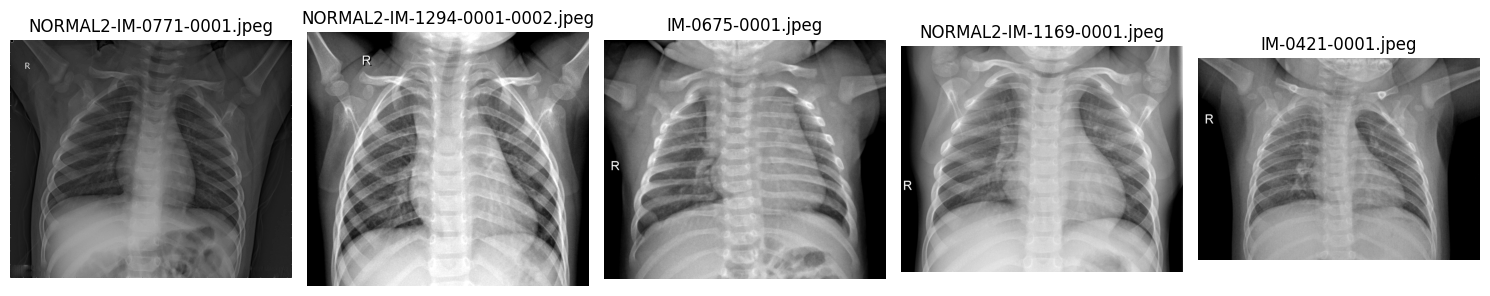

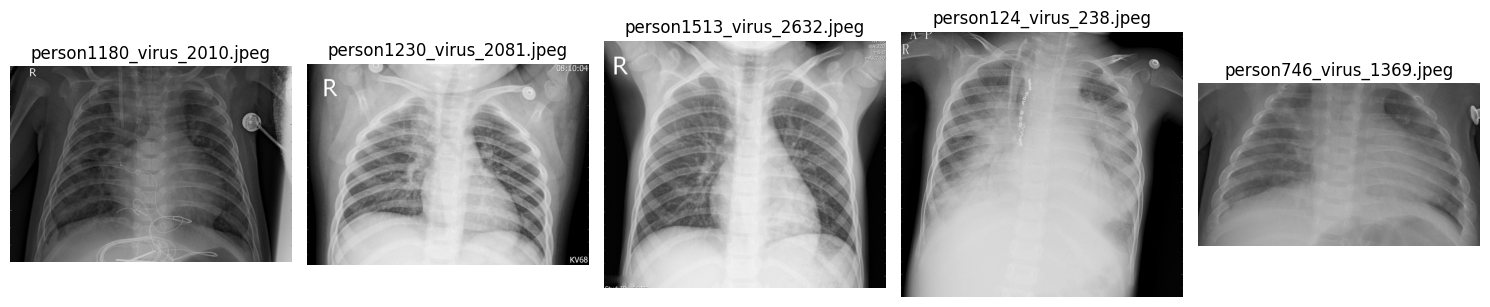

In [6]:
visualize_images(train_path + '/NORMAL', num_images=5)
visualize_images(train_path + '/PNEUMONIA', num_images=5)

In [7]:
filepath =[]
label = []

for path in paths:
    folds = [f for f in os.listdir(path) if not f.startswith('.')]  # Ignore hidden files

    for fold in folds:
        f_path = os.path.join(path , fold)
        imgs = os.listdir(f_path)
        
        for img in imgs:
            img_path = os.path.join(f_path , img)
            filepath.append(img_path)
            label.append(fold)
            
file_path_series = pd.Series(filepath , name= 'filepath')
Label_path_series = pd.Series(label , name = 'label')
data = pd.concat([file_path_series ,Label_path_series ] , axis = 1)

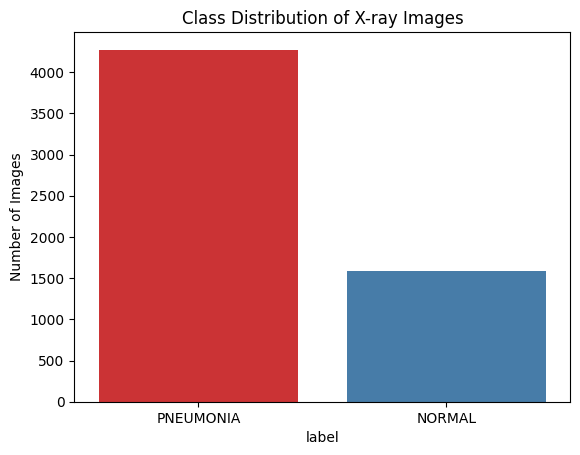

In [8]:
sns.countplot(data, x = 'label', palette = 'Set1')
plt.title("Class Distribution of X-ray Images")
plt.ylabel("Number of Images")
plt.show()

In [9]:
class_counts = data['label'].value_counts()
print("Image Count per Class:")
print(class_counts)
percentage = (class_counts[1]/class_counts[0]) * 100
print("Percentage of Gap: {:.1f}".format(percentage),"%")

Image Count per Class:
label
PNEUMONIA    4273
NORMAL       1583
Name: count, dtype: int64
Percentage of Gap: 37.0 %


<ipython-input-9-f34a1764f240>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  percentage = (class_counts[1]/class_counts[0]) * 100


The dataset is quite imbalanced.

Imbalanced dataset can be less impactful.

Then, how can we solve this problem?

In [10]:
ds_train = image_dataset_from_directory(
    train_path,
    validation_split = 0.15,
    subset = 'training',
    seed = 111,
    image_size = image_size,
    batch_size = batch_size,
    shuffle = True,
)

ds_val = image_dataset_from_directory(
    train_path,
    validation_split = 0.15,
    subset = 'validation',
    seed = 111,
    image_size = image_size,
    batch_size = batch_size,
    shuffle = True,
)

ds_test = image_dataset_from_directory(
    test_path,
    seed = 111,
    image_size = image_size,
    batch_size = batch_size,
    shuffle = True,
)



Found 5216 files belonging to 2 classes.
Using 4434 files for training.
Found 5216 files belonging to 2 classes.
Using 782 files for validation.
Found 624 files belonging to 2 classes.


In [11]:
# Extract labels
train_labels = ds_train.class_names
test_labels = ds_test.class_names
val_labels = ds_val.class_names

# Define your class labels
class_labels = ['NORMAL', 'PNEUMONIA'] 

# Instantiate LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder on the class labels
label_encoder.fit(class_labels)

train_labels_encoded = label_encoder.transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)
val_labels_encoded = label_encoder.transform(val_labels)

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = ds_train.map(lambda x, y: (x / 255.0, y)).cache().prefetch(buffer_size=AUTOTUNE)
ds_val = ds_val.map(lambda x, y: (x / 255.0, y)).cache().prefetch(buffer_size=AUTOTUNE)
ds_test = ds_test.map(lambda x, y: (x / 255.0, y)).cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
vgg16_weights_path = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
transfer_base = VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(256, 256, 3))
transfer_base.trainable = False

model = keras.Sequential([
    transfer_base,
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 512)                 │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,864,577 (56.70 MB)

 Trainable params: 148,865 (581.50 KB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    ds_train,
    epochs= 20,
    validation_data = ds_val,
    callbacks = early_stopping,
)

Epoch 1/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 81s 425ms/step - binary_accuracy: 0.8989 - loss: 0.2343 - val_binary_accuracy: 0.8491 - val_loss: 0.3328
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 30s 219ms/step - binary_accuracy: 0.9626 - loss: 0.1017 - val_binary_accuracy: 0.9642 - val_loss: 0.1998
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 34s 244ms/step - binary_accuracy: 0.9646 - loss: 0.0909 - val_binary_accuracy: 0.9719 - val_loss: 0.1200
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 32s 232ms/step - binary_accuracy: 0.9691 - loss: 0.0771 - val_binary_accuracy: 0.9770 - val_loss: 0.0852
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 32s 233ms/step - binary_accuracy: 0.9767 - loss: 0.0654 - val_binary_accuracy: 0.9770 - val_loss: 0.0798
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 33s 237ms/step - binary_accuracy: 0.9768 - loss: 0.0601 - val_binary_accuracy: 0.9706 - val_loss: 0.0821
Epoch 7/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 33s 235ms/step - binary_accuracy: 0.9802 - loss: 0.0542 - val_binary_accuracy: 0.9744 - va

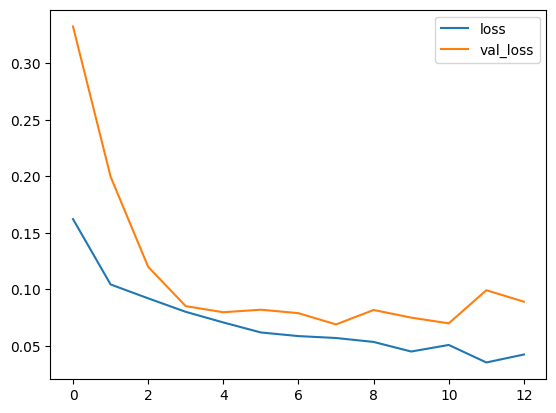

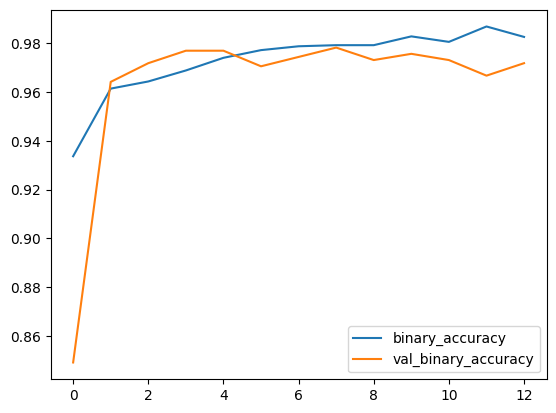

In [16]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();


In [19]:
validation_loss, validation_accuracy = model.evaluate(ds_val)
# Print the validation loss and accuracy
print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)

25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 198ms/step - binary_accuracy: 0.9840 - loss: 0.0554
Validation Loss: 0.06904055923223495
Validation Accuracy: 0.97826087474823


Testing Images:
Found 624 files belonging to 2 classes.
Testing Images:
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step


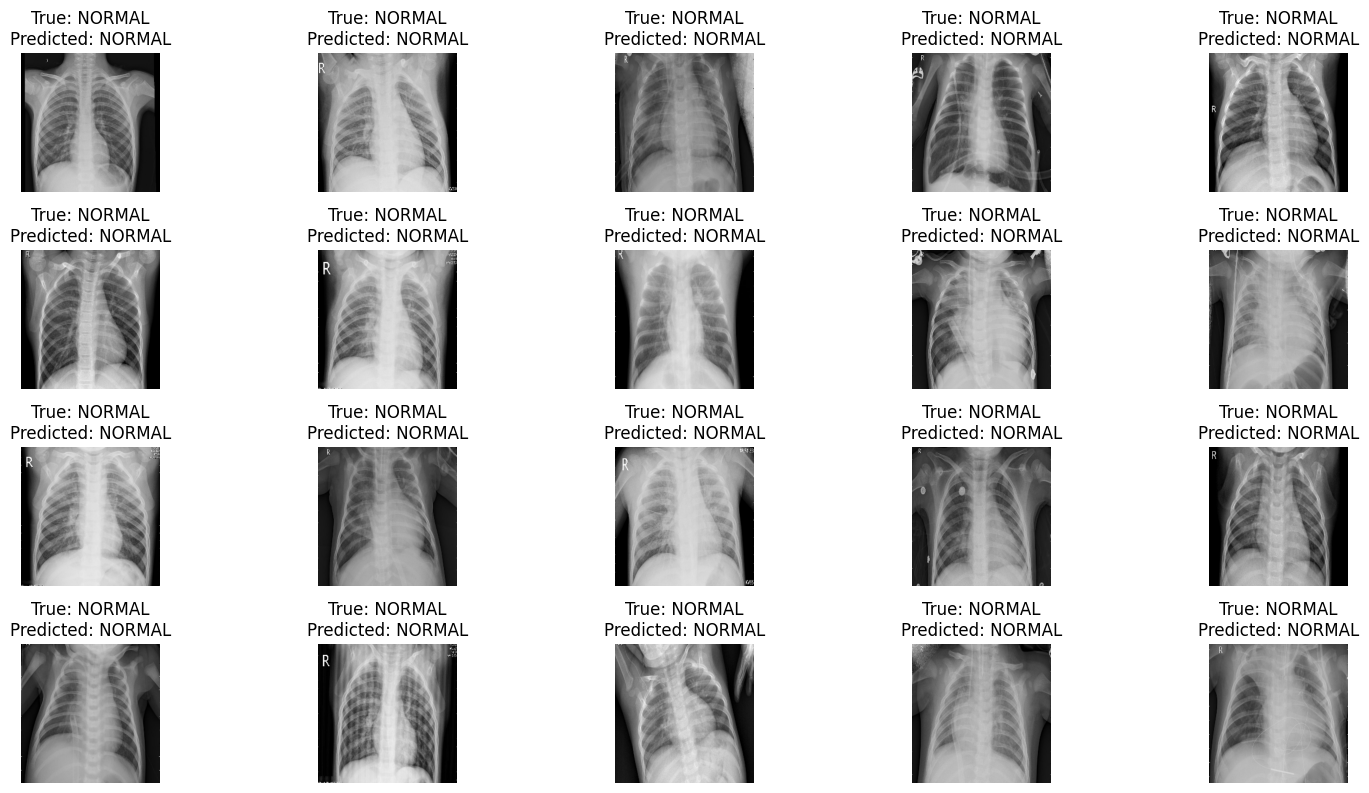

In [30]:
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/'
print('Testing Images:')
ds_test = tf.keras.utils.image_dataset_from_directory(
    test_dir, 
    seed=123,
    image_size=image_size,
    batch_size=32)

def plot_images_with_predictions(model, dataset, class_labels, num_images=40, num_images_per_row=5):
    # Generate predictions for a set number of images
    predictions = model.predict(dataset)
    
    # Shuffle the dataset
    dataset_shuffled = dataset.shuffle(buffer_size=len(dataset))
    
    plt.figure(figsize=(15, 10))
    for i, (images, labels) in enumerate(dataset_shuffled.take(num_images)):
        # Convert tensor to NumPy array
        images = images.numpy()
        
        # Iterate over each image in the batch
        for j in range(len(images)):
            if i * num_images_per_row + j < num_images:  # Check if the total number of images exceeds the desired count
                predicted_class = class_labels[np.argmax(predictions[i * num_images_per_row + j])]
                true_class = class_labels[np.argmax(labels[j])]
                
                plt.subplot(num_images // num_images_per_row + 1, num_images_per_row, i * num_images_per_row + j + 1)
                plt.imshow(images[j].astype("uint8"))  
                plt.title(f'True: {true_class}\nPredicted: {predicted_class}')
                plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize predictions on random 20 images from the testing dataset
print('Testing Images:')
plot_images_with_predictions(model,ds_test, class_labels, num_images=20)